In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r /content/chest.zip "/content/drive/MyDrive/chest-xray"




zip error: Interrupted (aborting)


In [ ]:
!unzip /content/chest.zip -d /content/chest_fast


Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2118).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2297).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2179).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2327).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2187).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2274).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pneumonia-Bacterial/Pneumonia-Bacterial (2218).jpg  
  inflating: /content/chest_fast/content/drive/MyDrive/chest-xray/train/Pn

In [ ]:
data_dir = "/content/drive/MyDrive/chest-xray"


In [ ]:
import os
os.listdir(data_dir)
data_dir

'/content/drive/MyDrive/chest-xray'

In [ ]:
test_dir= data_dir+"/test"
train_dir= data_dir+"/train"
val_dir= data_dir+"/val"

In [ ]:
os.listdir(train_dir)

['Pneumonia-Viral',
 'Emphysema',
 'Covid-19',
 'Normal',
 'Pneumonia-Bacterial',
 'Tuberculosis']

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1,
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_ds = val_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical"
)


Found 14551 images belonging to 6 classes.
Found 1748 images belonging to 6 classes.
Found 1737 images belonging to 6 classes.


## Building RESNET50 Model

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze base layers for stability
for layer in base.layers:
    layer.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(6, activation='softmax')(x)


model = Model(inputs=base.input, outputs=output)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,798 (91.99 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.1940 - loss: 1.8486

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


455/455 ━━━━━━━━━━━━━━━━━━━━ 4264s 9s/step - accuracy: 0.1941 - loss: 1.8485 - val_accuracy: 0.2855 - val_loss: 1.7100 - learning_rate: 1.0000e-04
Epoch 2/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 3539s 8s/step - accuracy: 0.3045 - loss: 1.7127 - val_accuracy: 0.2294 - val_loss: 1.6521 - learning_rate: 1.0000e-04
Epoch 3/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 3539s 8s/step - accuracy: 0.3551 - loss: 1.6449 - val_accuracy: 0.4354 - val_loss: 1.5555 - learning_rate: 1.0000e-04
Epoch 4/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 3579s 8s/step - accuracy: 0.4129 - loss: 1.5791 - val_accuracy: 0.5509 - val_loss: 1.4832 - learning_rate: 1.0000e-04
Epoch 5/10
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4294 - loss: 1.5280

KeyboardInterrupt: 

In [ ]:
model.save("/content/drive/MyDrive/chest_model_resnet50.h5")

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


55/55 ━━━━━━━━━━━━━━━━━━━━ 453s 8s/step - accuracy: 0.5271 - loss: 1.4543
Test Accuracy: 0.45998847484588623


In [ ]:
class_names = list(train_ds.class_indices.keys())
print(class_names)


['Covid-19', 'Emphysema', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral', 'Tuberculosis']


In [ ]:
def predict_xray(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert to array
    img_array = image.img_to_array(img)

    # Normalize
    img_array = img_array / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    index = np.argmax(preds)

    print("Predicted Class:", class_names[index])
    print("Confidence:", preds[0][index])

    # Show image
    plt.imshow(image.load_img(img_path))
    plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: Covid-19
Confidence: 0.2451171


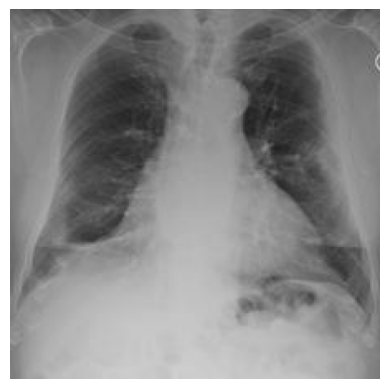

In [ ]:
img_var="/content/drive/MyDrive/chest-xray/val/Covid-19/COVID-19 (219).jpg"
predict_xray(img_var)
